In [86]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sb

from glob import glob
import librosa
import librosa.display
from copy import deepcopy
import soundfile as sf

import IPython.display as ipd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)
from tqdm.notebook import tqdm as pb
from IPython.display import clear_output

# Read audio file

In [6]:
audio_file = glob('female_sound_with_car_noise.wav')

In [8]:
ipd.Audio(audio_file[0])

In [16]:
audio_data, sr = librosa.load(audio_file[0])
print(f'audio_data: {audio_data[:10]}')
print(f'shape of audio_data: {audio_data.shape}')
print(f'sr: {sr}')

audio_data: [-0.00799758 -0.01185634 -0.0084738  -0.00739782 -0.00643065 -0.00810613
 -0.00942354 -0.01030931 -0.00999604 -0.00940564]
shape of audio_data: (100141,)
sr: 22050


In [14]:
audio_data

array([-0.00799758, -0.01185634, -0.0084738 , ...,  0.00590632,
        0.00276059,  0.        ], dtype=float32)

<AxesSubplot:title={'center':'Female Audio With Noise'}>

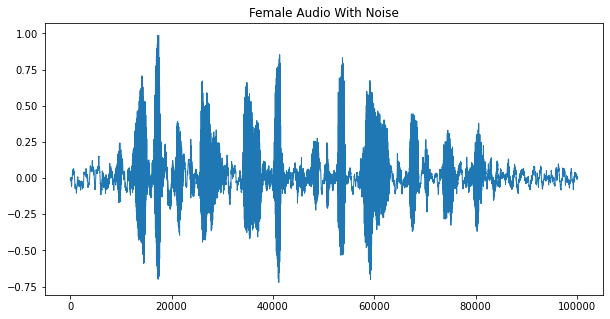

In [18]:
pd.Series(audio_data).plot(figsize=(10,5), lw=1, title='Female Audio With Noise')

# estimate amplitude  of sound using LMMSE

In [23]:
df_audio = pd.DataFrame(audio_data, columns=['amplitude_noisy'])

In [24]:
df_audio

,amplitude_noisy
0,-0.007998
1,-0.011856
2,-0.008474
3,-0.007398
4,-0.006431
...,...
100136,0.008727
100137,0.008037
100138,0.005906
100139,0.002761


In [104]:
variances_amplitude_observed = []
covariances_amplitude_observed = []
for index, row in pb(df_audio.iterrows(), total=len(df_audio)):
    # we observe the first 3 amplitudes of the speech and initialize the amplitudes
    if (index == 0) or (index == 1) or (index == 2):
        df_audio.loc[index, 'amplitude_estimated'] = df_audio.loc[index, 'amplitude_noisy']
    else:
    # estimate subsequent amplitude observations using LMMSE
        a = (df_audio['amplitude_noisy'][0:index-1].cov(df_audio['amplitude_estimated'][0:index-1])) / (df_audio['amplitude_estimated'][0:index-1].var())
        b = (df_audio['amplitude_noisy'][0:index-1].mean()) - a * (df_audio['amplitude_estimated'][0:index-1].mean())
        df_audio.loc[index, 'amplitude_estimated'] = a*(df_audio.loc[index-1, 'amplitude_noisy']) + b
        variances_amplitude_observed.append(df_audio['amplitude_noisy'][0:index-1].var())
        covariances_amplitude_observed.append(df_audio['amplitude_noisy'][0:index-1].cov(df_audio['amplitude_estimated'][0:index-1]))

  0%|          | 0/100141 [00:00<?, ?it/s]

In [105]:
covariances_amplitude_observed

[7.445025147257995e-06,
 4.426406456440058e-06,
 3.4461640974989653e-06,
 3.486165829977363e-06,
 2.9463276551093504e-06,
 2.3407284263818847e-06,
 2.2181754546911237e-06,
 2.167085725120492e-06,
 2.0008145041633614e-06,
 1.8163462450837595e-06,
 1.6519497253434048e-06,
 1.5117699937402786e-06,
 1.3878458488126978e-06,
 1.3083165462797624e-06,
 1.2646497308034323e-06,
 1.2229888765287009e-06,
 1.1642832168566975e-06,
 1.099767434865506e-06,
 1.041628224130615e-06,
 9.95232829907575e-07,
 9.821975197157694e-07,
 1.0635537093299202e-06,
 1.3401341278535423e-06,
 1.8900978104458305e-06,
 2.7136262384068437e-06,
 3.6167883023470806e-06,
 4.339562321763469e-06,
 4.845321554116349e-06,
 5.281064879698641e-06,
 5.8167084248493926e-06,
 6.595355161196998e-06,
 7.670799608490382e-06,
 8.93983727880945e-06,
 1.0177638044276936e-05,
 1.1202396880184294e-05,
 1.1992363096698277e-05,
 1.2616426333152288e-05,
 1.3137403834562078e-05,
 1.3560468808815797e-05,
 1.3834826891130209e-05,
 1.3917373343880

In [129]:
amplitude_estimated_array = df_audio['amplitude_estimated'].to_numpy()
sf.write('test_file.wav', amplitude_estimated_array, sr)

In [130]:
clean_audio = glob('test_file.wav')
ipd.Audio(clean_audio[0])

In [108]:
audio_data_cleaned, sr_cleaned = librosa.load(clean_audio[0])

In [ ]:
color_pal

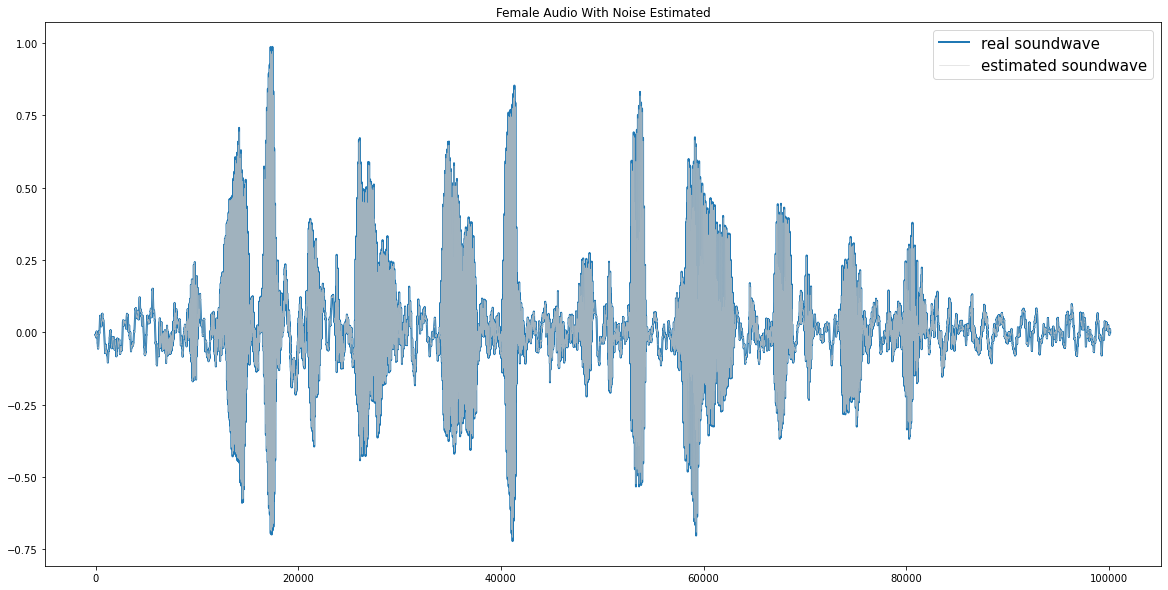

In [171]:
# pd.Series(audio_data).plot(figsize=(40,20), lw=1, title='Female Audio With Noise', linestyle = '--')
pd.Series(audio_data).plot(figsize=(20,10), lw=2,  alpha = 2, title='Female Audio With Noise', label = 'real soundwave')
pd.Series(audio_data_cleaned).plot(figsize=(20,10), lw=0.5, alpha = 0.8,  title='Female Audio With Noise Estimated', color='#c1c1c1', label = 'estimated soundwave')
plt.legend(loc='upper right', fontsize = 15)

# Python implementation of LMMSE